In [19]:
import os
os.environ['OMP_NUM_THREADS'] = '4'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openai
import math
# openai.api_key = os.environ['OPENAI_API_KEY']
openai.api_key = 'your api key'
from data.serialize import SerializerSettings
from models.utils import grid_iter
from models.promptcast import get_promptcast_predictions_data
from models.darts import get_arima_predictions_data
from models.llmtime import get_llmtime_predictions_data
from data.small_context import get_datasets
from models.validation_likelihood_tuning import get_autotuned_predictions_data

%load_ext autoreload
%autoreload 2

d:\software\python\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
gpt4_hypers = dict(
    alpha=0.3,
    basic=True,
    temp=1.0,
    top_p=0.8,
    settings=SerializerSettings(base=10, prec=3, signed=True, time_sep=', ', bit_sep='', minus_sign='-')
)

gpt3_hypers = dict(
    temp=0.7,
    alpha=0.95,
    beta=0.3,
    basic=False,
    settings=SerializerSettings(base=10, prec=3, signed=True, half_bin_correction=True)
)


promptcast_hypers = dict(
    temp=0.7,
    settings=SerializerSettings(base=10, prec=0, signed=True, 
                                time_sep=', ',
                                bit_sep='',
                                plus_sign='',
                                minus_sign='-',
                                half_bin_correction=False,
                                decimal_point='')
)

arima_hypers = dict(p=[12,30], d=[1,2], q=[0])

model_hypers = {
    'LLMTime GPT-3.5': {'model': 'gpt-3.5-turbo-instruct', **gpt3_hypers},
    # 'LLMTime GPT-4': {'model': 'gpt-4', **gpt4_hypers},
    # 'LLMTime GPT-3': {'model': 'text-davinci-003', **gpt3_hypers},
    # 'PromptCast GPT-3': {'model': 'text-davinci-003', **promptcast_hypers},
    # 'PromptCast GPT-3.5':{'model': 'gpt-3.5-turbo-instruct', **promptcast_hypers},
    'ARIMA': arima_hypers,
    
}

model_predict_fns = {
    'LLMTime GPT-3.5': get_llmtime_predictions_data,
    # 'LLMTime GPT-3': get_llmtime_predictions_data,
    # 'LLMTime GPT-4': get_llmtime_predictions_data,
    # 'PromptCast GPT-3': get_promptcast_predictions_data,
    'ARIMA': get_arima_predictions_data,
}

model_names = list(model_predict_fns.keys())

In [17]:
def plot_preds(train, test, pred_dict, model_name, mse, show_samples=False):
    pred = pred_dict['median']
    pred = pd.Series(pred, index=test.index)
    plt.figure(figsize=(8, 6), dpi=100)
    plt.title(model_name)
    plt.plot(train)
    plt.plot(test, label='Truth', color='black')
    plt.plot(pred, label=model_name, color='purple')
    if show_samples:
        samples = pred_dict['samples']
        # convert df to numpy array
        samples = samples.values if isinstance(samples, pd.DataFrame) else samples
        for i in range(min(10, samples.shape[0])):
            plt.plot(pred.index, samples[i], color='purple', alpha=0.3, linewidth=1)
    plt.legend(loc='upper left')
    mse_name = model_name + '_mse'
    # plt.text(0.03, 0.85, f'{mse_name}: {mse:.2f} ')
    plt.text(0.03, 0.85, f'{mse_name}: {mse:.4f} ', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()

In [18]:
from sklearn.metrics import mean_squared_error
def out(train, test, ds_name, model_hypers=model_hypers, model_names=model_names):
    out = {}
    for model in model_names: # GPT-4 takes a about a minute to run
        model_hypers[model].update({'dataset_name': ds_name}) # for promptcast
        hypers = list(grid_iter(model_hypers[model]))
        num_samples = 10
        pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=False, parallel=False)
        out[model] = pred_dict
        
        pred = pred_dict['median']
        pred = pd.Series(pred, index=test.index)
        mse = mean_squared_error(test, pred)
        out[model+"_mse"] = mse
        plot_preds(train, test, pred_dict, model, mse, show_samples=False)
    return out

In [34]:
def diff_sigmas(sigma):
    x = np.linspace(0, 8 * math.pi, 500)
    y = np.cos(2 * x) + np.cos(2 * math.pi * x)
    
    mean = 0 
    noise = np.random.normal(mean, sigma , len(x))
    y_with_noise = y + noise 
    y_with_noise = np.around(y_with_noise, decimals=2)
    series = pd.Series(y_with_noise)
    
    testfrac=0.2
    splitpoint = int(len(series)*(1-testfrac))
    train = series[:splitpoint]
    test = series[splitpoint:]

    plt.figure(figsize=(8, 6), dpi=100)
    plt.plot(x[:splitpoint], train, label='train')
    plt.plot(x[splitpoint:], test, label='test')
    plt.title('sigma=' + str(sigma))
    plt.legend()
    plt.show()
    
    return out(train, test, 'cosines', model_hypers, model_names)
    

In [62]:
mse_result = dict()

# cos(2*pi*t)+cos(2*t)+noise（sigma=0）

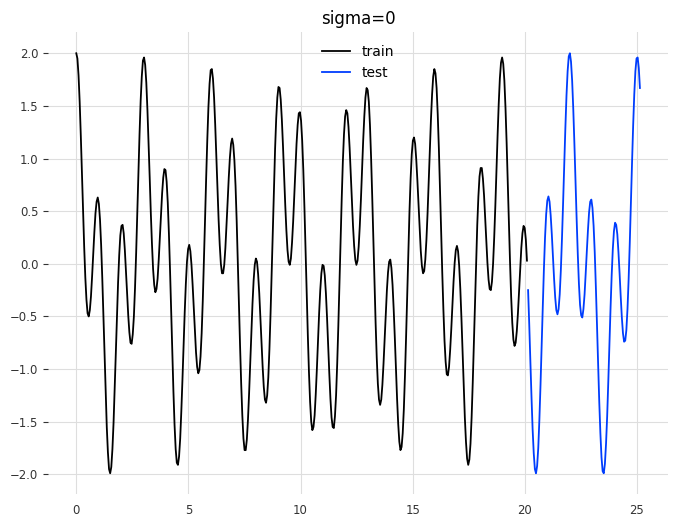

100%|██████████| 1/1 [00:11<00:00, 11.92s/it]


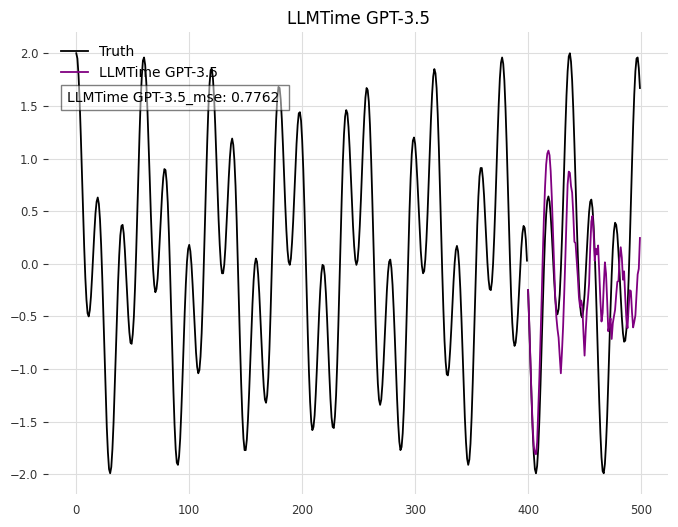

Train length: 300, Val length: 100


Hyperparameter search:  50%|█████     | 2/4 [00:01<00:01,  1.18it/s]d:\software\python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Hype

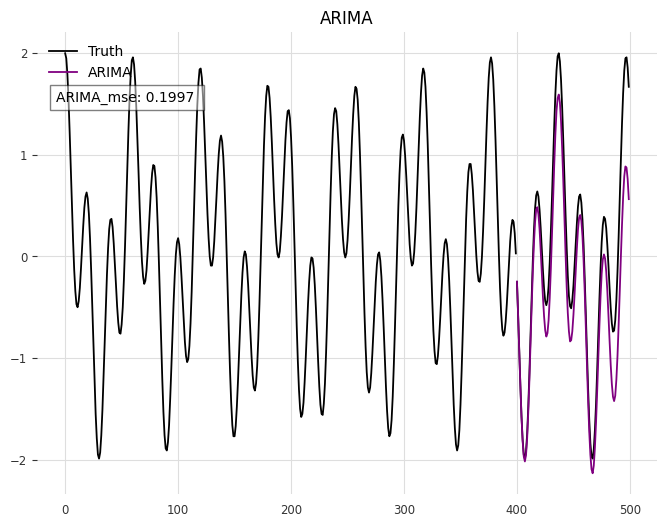

In [63]:
sigma = 0
res = diff_sigmas(sigma)
mse_result['sigma=' + str(sigma)] = {'LLMTime GPT-3.5_mse' :res['LLMTime GPT-3.5_mse'], 'ARIMA_mse': res['ARIMA_mse']}

# cos(2*pi*t)+cos(2*t)+noise（sigma=0.1）

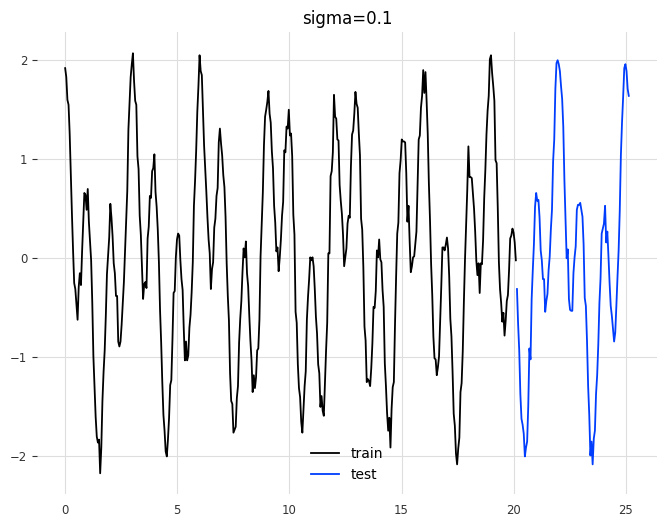

100%|██████████| 1/1 [00:12<00:00, 12.19s/it]


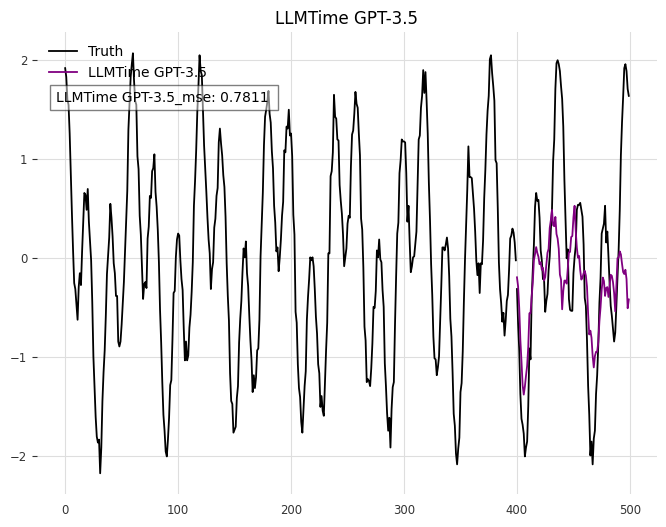

Train length: 300, Val length: 100


Hyperparameter search:  25%|██▌       | 1/4 [00:01<00:03,  1.22s/it]d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Hyperparameter search:  50%|█████     | 2/4 [00:02<00:02,  1.21s/it]d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization 

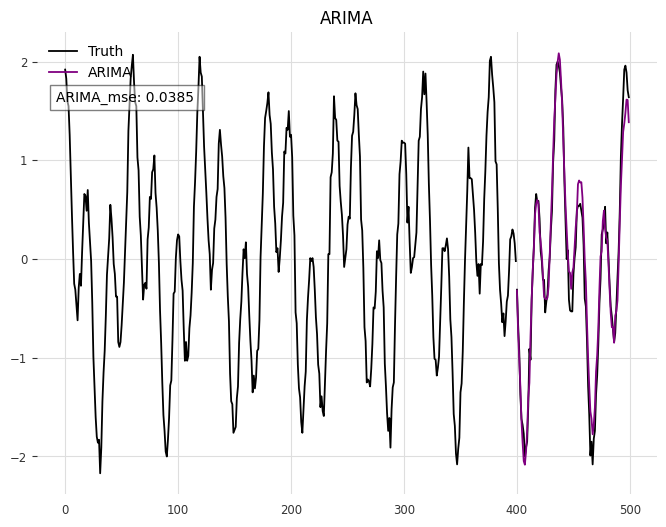

In [64]:
sigma = 0.1
res = diff_sigmas(sigma)
mse_result['sigma=' + str(sigma)] = {'LLMTime GPT-3.5_mse' :res['LLMTime GPT-3.5_mse'], 'ARIMA_mse': res['ARIMA_mse']}

# cos(2*pi*t)+cos(2*t)+noise（sigma=0.2）

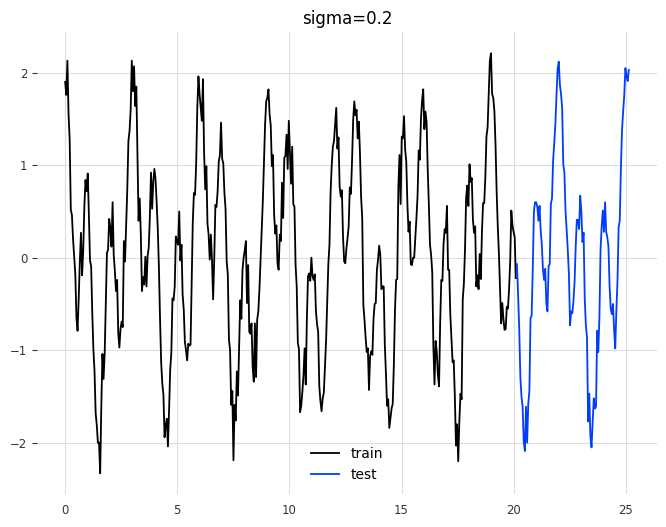

100%|██████████| 1/1 [00:11<00:00, 11.97s/it]


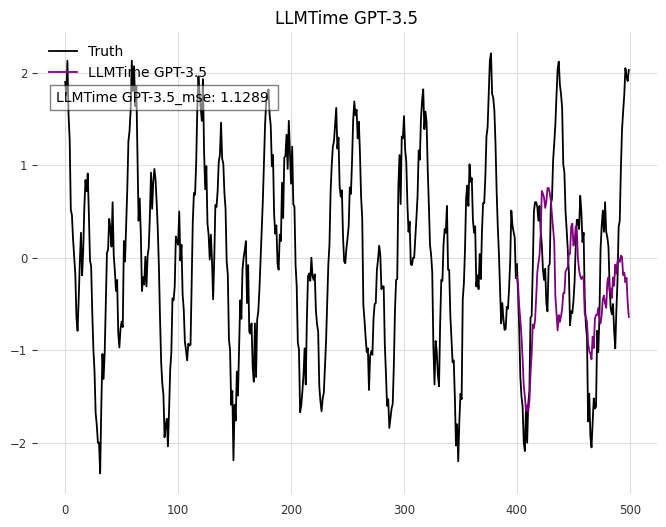

Train length: 300, Val length: 100


Hyperparameter search:   0%|          | 0/4 [00:00<?, ?it/s]d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Hyperparameter search:  50%|█████     | 2/4 [00:01<00:01,  1.12it/s]d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed t

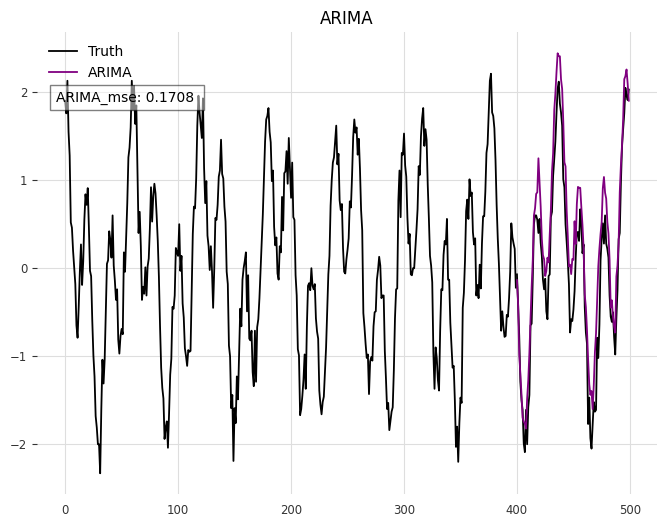

In [66]:
sigma = 0.2
res = diff_sigmas(sigma)
mse_result['sigma=' + str(sigma)] = {'LLMTime GPT-3.5_mse' :res['LLMTime GPT-3.5_mse'], 'ARIMA_mse': res['ARIMA_mse']}

# cos(2*pi*t)+cos(2*t)+noise（sigma=0.3）

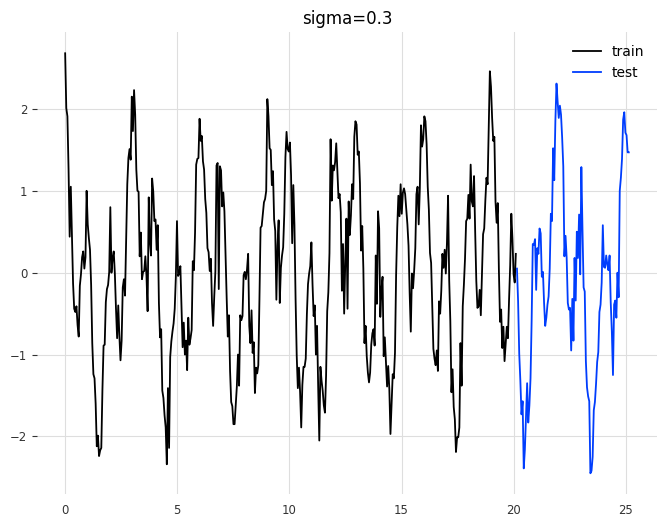

100%|██████████| 1/1 [00:11<00:00, 11.81s/it]


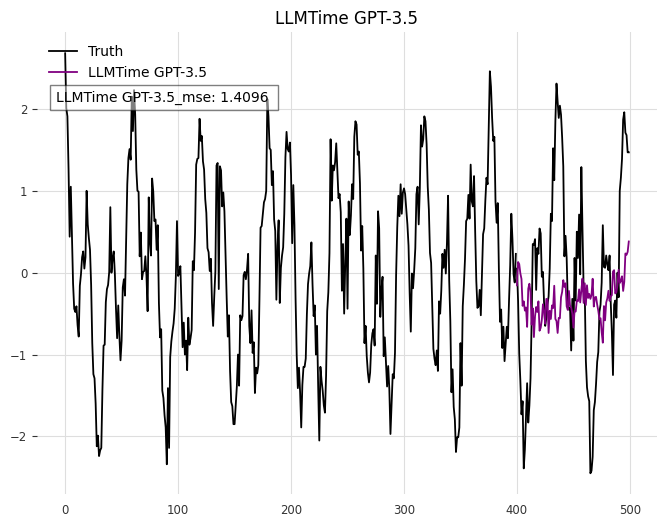

Train length: 300, Val length: 100


Hyperparameter search:  50%|█████     | 2/4 [00:01<00:01,  1.96it/s]d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Hyperparameter search:  75%|███████▌  | 3/4 [00:08<00:03,  3.52s/it]d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization 

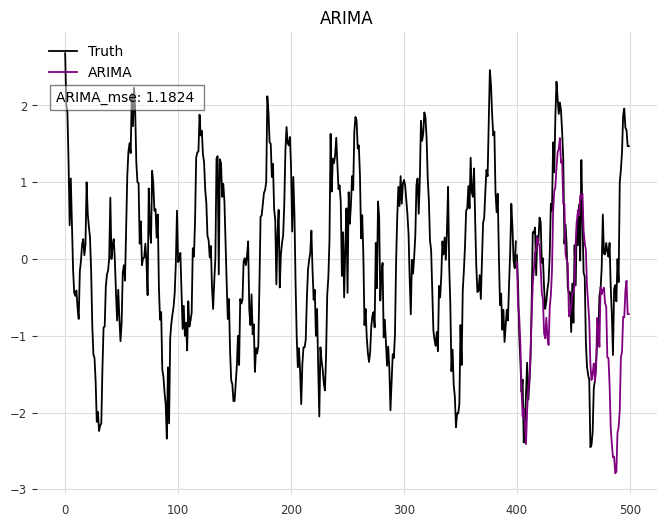

In [67]:
sigma = 0.3
res = diff_sigmas(sigma)
mse_result['sigma=' + str(sigma)] = {'LLMTime GPT-3.5_mse' :res['LLMTime GPT-3.5_mse'], 'ARIMA_mse': res['ARIMA_mse']}

# cos(2*pi*t)+cos(2*t)+noise（sigma=0.4）

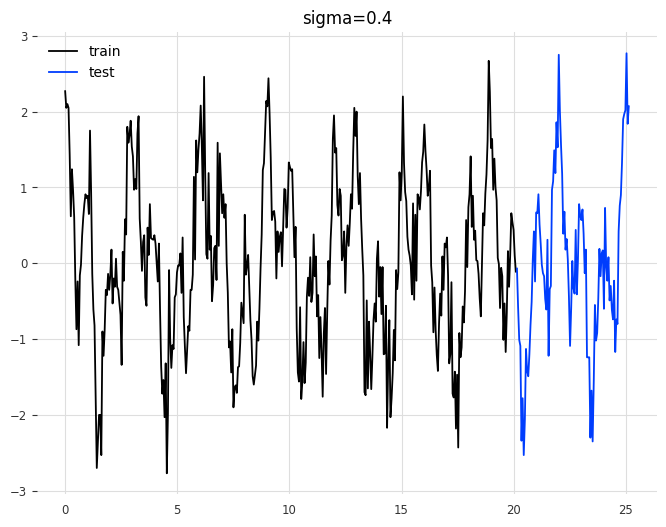

100%|██████████| 1/1 [00:12<00:00, 12.14s/it]


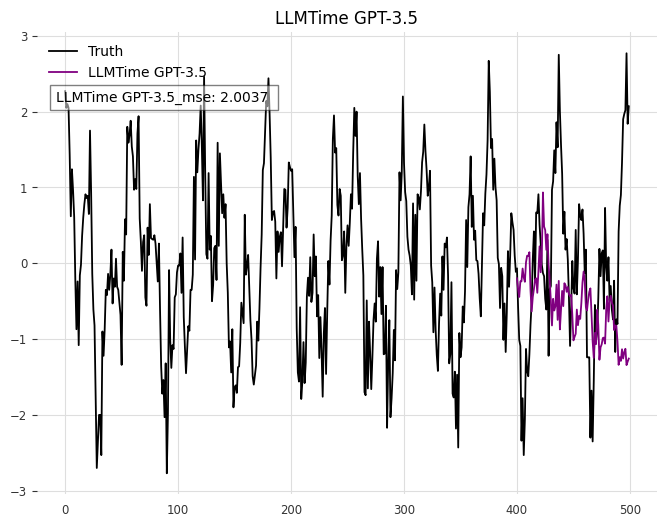

Train length: 300, Val length: 100


Hyperparameter search:  50%|█████     | 2/4 [00:01<00:01,  1.81it/s]d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Hyperparameter search:  75%|███████▌  | 3/4 [00:08<00:03,  3.54s/it]d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization 

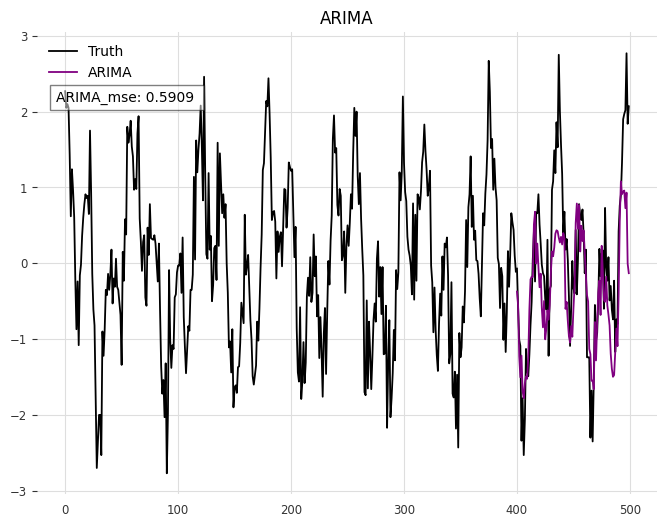

In [68]:
sigma = 0.4
res = diff_sigmas(sigma)
mse_result['sigma=' + str(sigma)] = {'LLMTime GPT-3.5_mse' :res['LLMTime GPT-3.5_mse'], 'ARIMA_mse': res['ARIMA_mse']}

In [69]:
mse_result

{'sigma=0': {'LLMTime GPT-3.5_mse': 0.776165887233953,
  'ARIMA_mse': 0.19967751638105255},
 'sigma=0.1': {'LLMTime GPT-3.5_mse': 0.781126571627594,
  'ARIMA_mse': 0.03848711994986286},
 'sigma=0.2': {'LLMTime GPT-3.5_mse': 1.1288975265570904,
  'ARIMA_mse': 0.17084367877789472},
 'sigma=0.3': {'LLMTime GPT-3.5_mse': 1.4095681833184182,
  'ARIMA_mse': 1.1824158656740145},
 'sigma=0.4': {'LLMTime GPT-3.5_mse': 2.0037019584471163,
  'ARIMA_mse': 0.5909099311896691}}

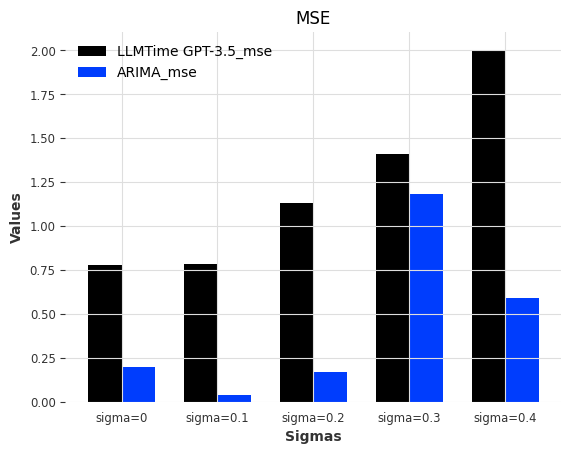

In [70]:
sigmas = []
y_llmtime = []
y_arimr = []
for mse in mse_result:
    sigmas.append(mse)
    y_llmtime.append(mse_result[mse]['LLMTime GPT-3.5_mse'])
    y_arimr.append(mse_result[mse]['ARIMA_mse'])
bar_width = 0.35
plt.bar([i - bar_width/2 for i in range(len(sigmas))], y_llmtime, width=bar_width, label='LLMTime GPT-3.5_mse')
plt.bar([i + bar_width/2 for i in range(len(sigmas))], y_arimr, width=bar_width, label='ARIMA_mse')
plt.legend()
plt.title('MSE')
plt.xlabel('Sigmas')
plt.ylabel('Values')
plt.xticks(range(len(sigmas)), sigmas)
plt.show()

In [30]:
def pred(ds_name, model, train, test, model_hypers=model_hypers, model_names=model_names):
    model_hypers[model].update({'dataset_name': ds_name}) # for promptcast
    hypers = list(grid_iter(model_hypers[model]))
    num_samples = 10
    pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=False, parallel=False)
    
    pred = pred_dict['median']
    pred = pd.Series(pred, index=test.index)
    mse = mean_squared_error(test, pred)
    return pred, mse

In [41]:
from sklearn.metrics import mean_squared_error
def out(train1, test1, ds_name1, train2, test2, ds_name2, model_hypers=model_hypers, model_names=model_names):
    out = {}
    for model in model_names: # GPT-4 takes a about a minute to run
        
        pred1, mse1 = pred(ds_name1, model, train1, test1, model_hypers=model_hypers, model_names=model_names)
        pred2, mse2 = pred(ds_name2, model, train2, test2, model_hypers=model_hypers, model_names=model_names)
        
        out[ds_name1 + model+"_mse"] = mse1
        out[ds_name2 + model+"_mse"] = mse2
        
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
        ax1.set_title(model)
        ax1.plot(train1)
        ax1.plot(test1, label='Truth', color='black')
        ax1.plot(pred1, label=model, color='purple')
        ax1.legend(loc='upper left')
        mse_name = ds_name1 + model + '_mse'
        ax1.text(0.03, 0.75, f'{mse_name}: {mse1:.4f} ', transform=ax1.transAxes, bbox=dict(facecolor='white', alpha=0.5))

        ax2.set_title(model)
        ax2.plot(train2)
        ax2.plot(test2, label='Truth', color='black')
        ax2.plot(pred2, label=model, color='purple')
        ax2.legend(loc='upper left')
        mse_name = ds_name2 + model + '_mse'
        ax2.text(0.03, 0.75, f'{mse_name}: {mse2:.4f} ', transform=ax2.transAxes, bbox=dict(facecolor='white', alpha=0.5))
        
        plt.tight_layout()
        plt.show()
    return out

# 0.2*x + sin(x) + noise sigma=0

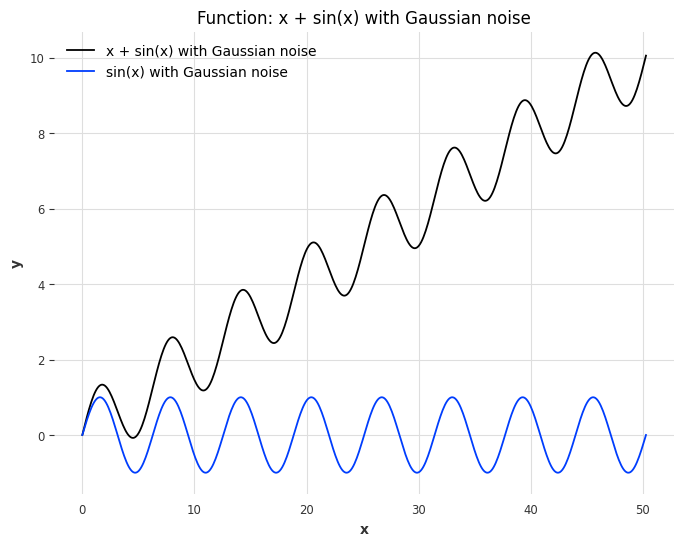

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import math

x = np.linspace(0, 16 * math.pi, 500)
noise = np.random.normal(0, 0, 500) 
y = np.sin(x) + noise
y_noise = 0.2 * x + y

testfrac=0.2
series1 = pd.Series(y)
splitpoint1 = int(len(series1)*(1-testfrac))
train1 = series1[:splitpoint1]
test1 = series1[splitpoint1:]

series2 = pd.Series(y_noise)
splitpoint2 = int(len(series2)*(1-testfrac))
train2 = series2[:splitpoint2]
test2 = series2[splitpoint2:]

plt.figure(figsize=(8, 6))
plt.plot(x, y_noise, label='x + sin(x) with Gaussian noise')
plt.plot(x, y, label='sin(x) with Gaussian noise')
plt.title('Function: x + sin(x) with Gaussian noise')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

100%|██████████| 1/1 [00:12<00:00, 12.59s/it]


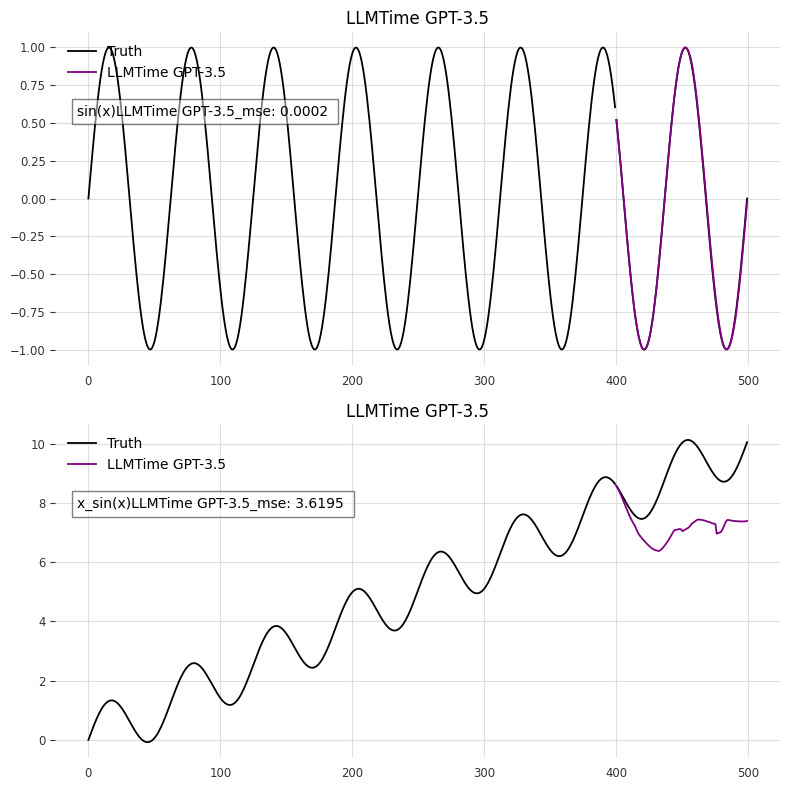

Train length: 300, Val length: 100


Hyperparameter search:   0%|          | 0/4 [00:00<?, ?it/s]d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Hyperparameter search:  25%|██▌       | 1/4 [00:04<00:13,  4.44s/it]d:\software\python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\software\python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  w

Train length: 300, Val length: 100


Hyperparameter search:   0%|          | 0/4 [00:00<?, ?it/s]d:\software\python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\software\python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
Hyperparameter search:  25%|██▌       | 1/4 [00:00<00:01,  2.36it/s]d:\software\python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\software\python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive param

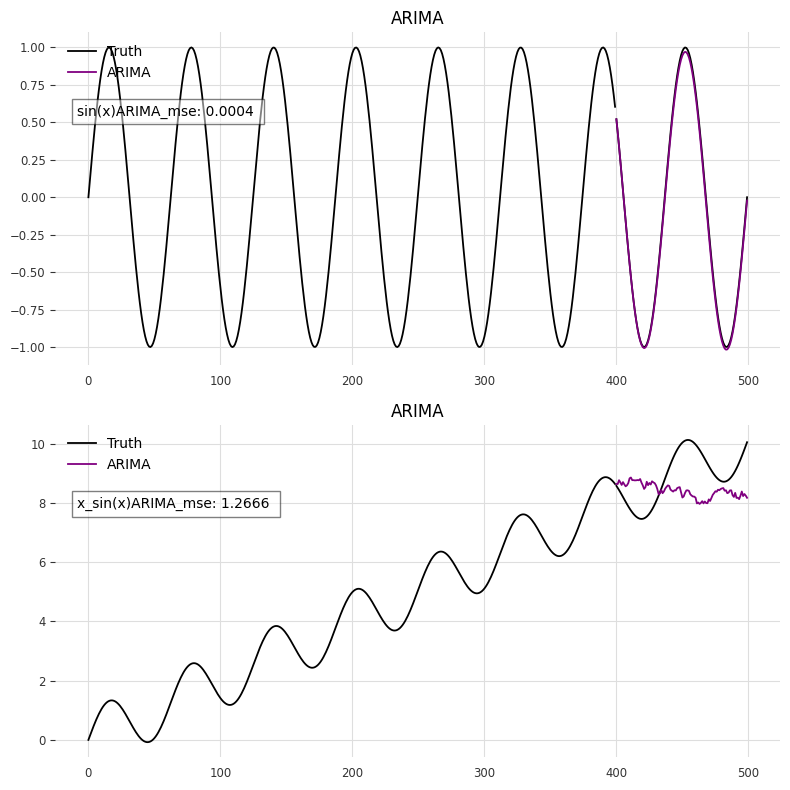

{'sin(x)LLMTime GPT-3.5_mse': 0.00016281851585661444,
 'x_sin(x)LLMTime GPT-3.5_mse': 3.6194722932657237,
 'sin(x)ARIMA_mse': 0.00041233669195690493,
 'x_sin(x)ARIMA_mse': 1.266587216398178}

In [44]:
out(train1, test1, "sin(x)", train2, test2, "x_sin(x)", model_hypers=model_hypers, model_names=model_names)

# 0.2*x + sin(x) + noise sigma=0.05

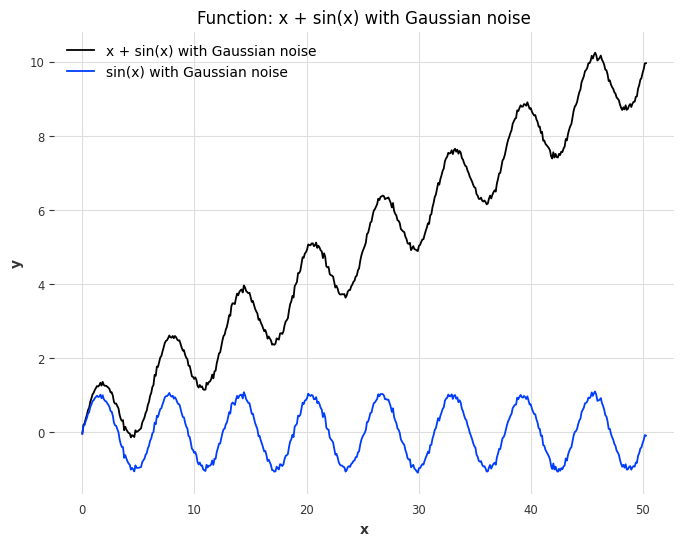

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import math

x = np.linspace(0, 16 * math.pi, 500)
noise = np.random.normal(0, 0.05, 500) 
y = np.sin(x) + noise
y_noise = 0.2 * x + y

testfrac=0.2
series1 = pd.Series(y)
splitpoint1 = int(len(series1)*(1-testfrac))
train1 = series1[:splitpoint1]
test1 = series1[splitpoint1:]

series2 = pd.Series(y_noise)
splitpoint2 = int(len(series2)*(1-testfrac))
train2 = series2[:splitpoint2]
test2 = series2[splitpoint2:]

plt.figure(figsize=(8, 6))
plt.plot(x, y_noise, label='x + sin(x) with Gaussian noise')
plt.plot(x, y, label='sin(x) with Gaussian noise')
plt.title('Function: x + sin(x) with Gaussian noise')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

100%|██████████| 1/1 [00:12<00:00, 12.53s/it]


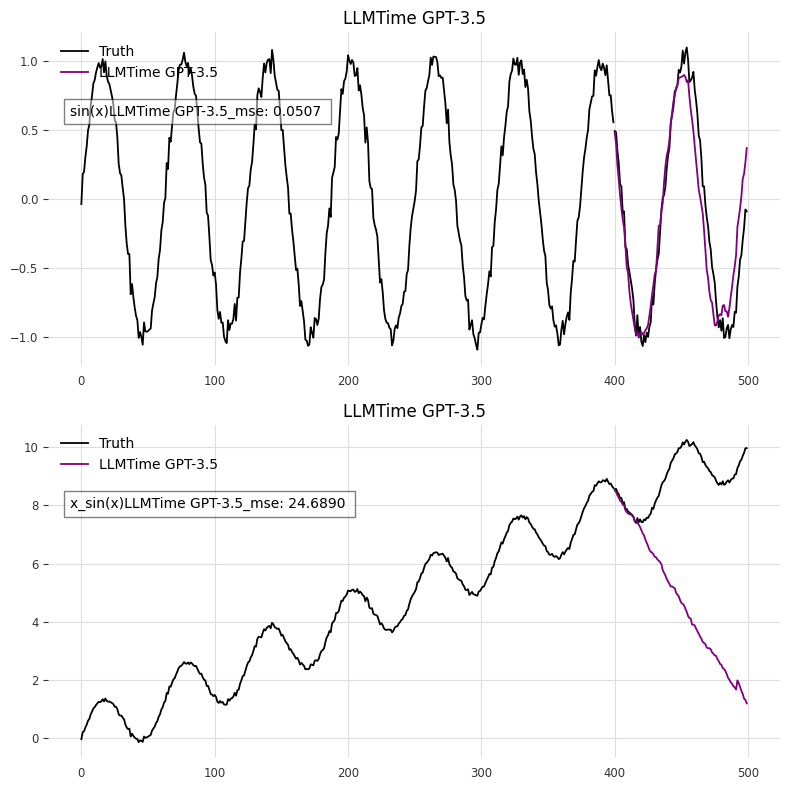

Train length: 300, Val length: 100


Hyperparameter search: 100%|██████████| 4/4 [00:11<00:00,  2.95s/it]
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Train length: 300, Val length: 100


Hyperparameter search:  75%|███████▌  | 3/4 [00:04<00:01,  1.85s/it]d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Hyperparameter search: 100%|██████████| 4/4 [00:11<00:00,  2.77s/it]


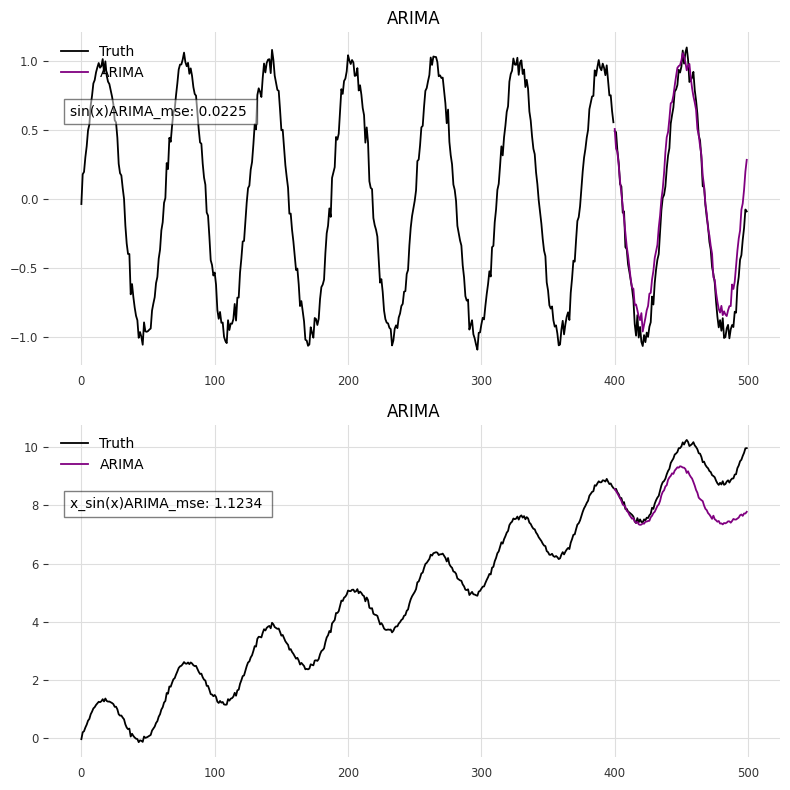

{'sin(x)LLMTime GPT-3.5_mse': 0.050669740731619804,
 'x_sin(x)LLMTime GPT-3.5_mse': 24.68903152680848,
 'sin(x)ARIMA_mse': 0.022533089234244172,
 'x_sin(x)ARIMA_mse': 1.1234440331313562}

In [46]:
out(train1, test1, "sin(x)", train2, test2, "x_sin(x)", model_hypers=model_hypers, model_names=model_names)

# 0.2*x + sin(x) + noise sigma=0.1

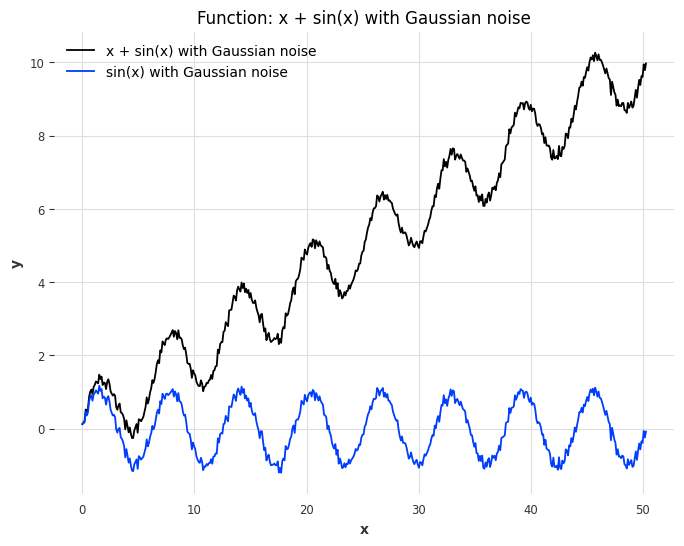

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import math

x = np.linspace(0, 16 * math.pi, 500)
noise = np.random.normal(0, 0.1, 500) 
y = np.sin(x) + noise
y_noise = 0.2 * x + y

testfrac=0.2
series1 = pd.Series(y)
splitpoint1 = int(len(series1)*(1-testfrac))
train1 = series1[:splitpoint1]
test1 = series1[splitpoint1:]

series2 = pd.Series(y_noise)
splitpoint2 = int(len(series2)*(1-testfrac))
train2 = series2[:splitpoint2]
test2 = series2[splitpoint2:]

plt.figure(figsize=(8, 6))
plt.plot(x, y_noise, label='x + sin(x) with Gaussian noise')
plt.plot(x, y, label='sin(x) with Gaussian noise')
plt.title('Function: x + sin(x) with Gaussian noise')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

100%|██████████| 1/1 [00:12<00:00, 12.73s/it]


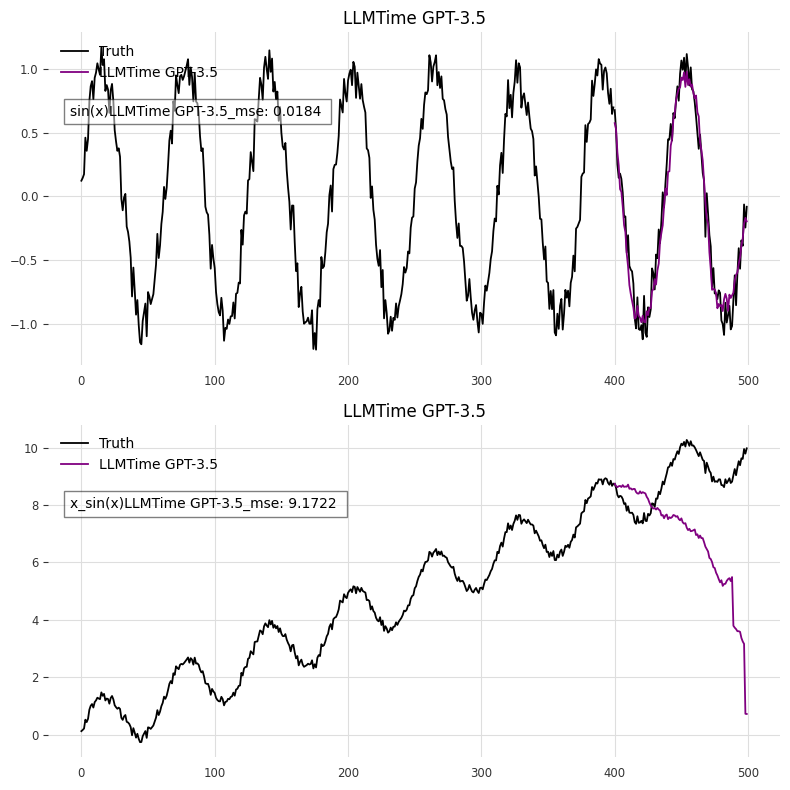

Train length: 300, Val length: 100


Hyperparameter search:  50%|█████     | 2/4 [00:01<00:01,  1.68it/s]d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Hyperparameter search:  75%|███████▌  | 3/4 [00:08<00:03,  3.73s/it]d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization 

Train length: 300, Val length: 100


Hyperparameter search:  50%|█████     | 2/4 [00:00<00:00,  2.10it/s]d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Hyperparameter search: 100%|██████████| 4/4 [00:14<00:00,  3.66s/it]


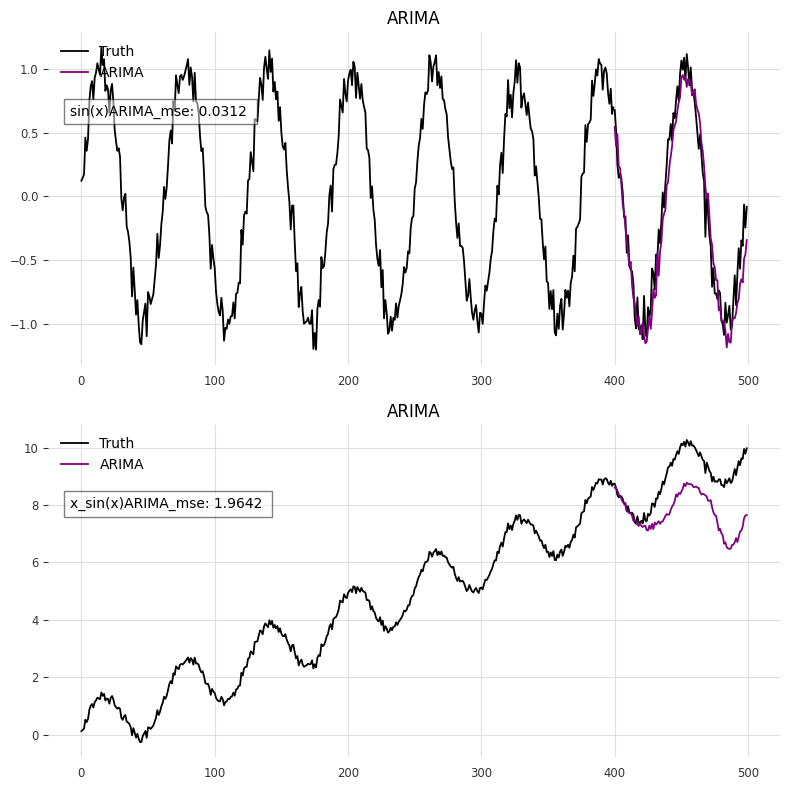

{'sin(x)LLMTime GPT-3.5_mse': 0.018372982846360963,
 'x_sin(x)LLMTime GPT-3.5_mse': 9.17217659014842,
 'sin(x)ARIMA_mse': 0.03119019675466485,
 'x_sin(x)ARIMA_mse': 1.9642496674521026}

In [48]:
out(train1, test1, "sin(x)", train2, test2, "x_sin(x)", model_hypers=model_hypers, model_names=model_names)

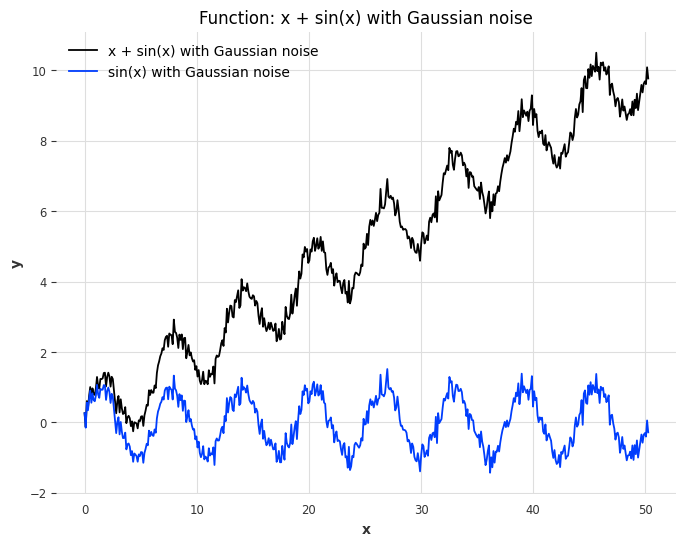

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import math

x = np.linspace(0, 16 * math.pi, 500)
noise = np.random.normal(0, 0.2, 500) 
y = np.sin(x) + noise
y_noise = 0.2 * x + y

testfrac=0.2
series1 = pd.Series(y)
splitpoint1 = int(len(series1)*(1-testfrac))
train1 = series1[:splitpoint1]
test1 = series1[splitpoint1:]

series2 = pd.Series(y_noise)
splitpoint2 = int(len(series2)*(1-testfrac))
train2 = series2[:splitpoint2]
test2 = series2[splitpoint2:]

plt.figure(figsize=(8, 6))
plt.plot(x, y_noise, label='x + sin(x) with Gaussian noise')
plt.plot(x, y, label='sin(x) with Gaussian noise')
plt.title('Function: x + sin(x) with Gaussian noise')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

100%|██████████| 1/1 [00:12<00:00, 12.34s/it]


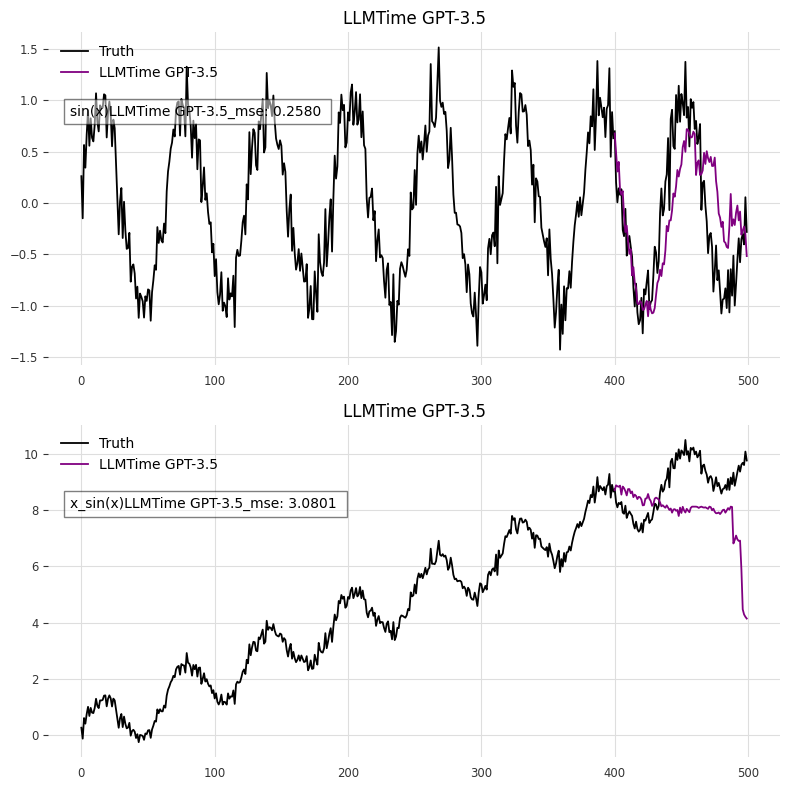

Train length: 300, Val length: 100


Hyperparameter search:  50%|█████     | 2/4 [00:01<00:01,  1.27it/s]d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Hyperparameter search: 100%|██████████| 4/4 [00:15<00:00,  3.89s/it]
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization

Train length: 300, Val length: 100


Hyperparameter search: 100%|██████████| 4/4 [00:16<00:00,  4.13s/it]
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


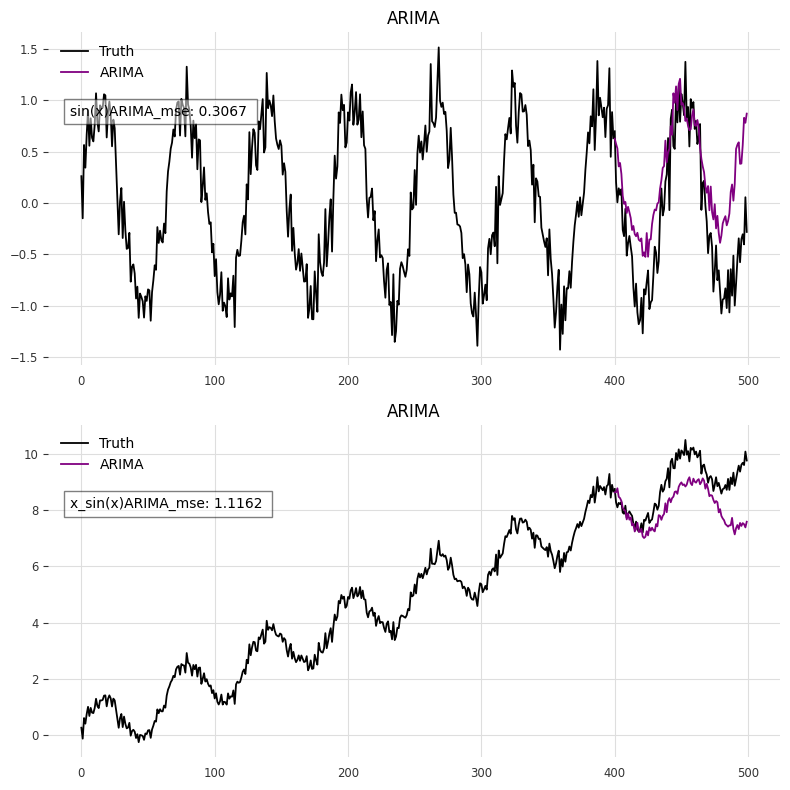

{'sin(x)LLMTime GPT-3.5_mse': 0.2579762479583536,
 'x_sin(x)LLMTime GPT-3.5_mse': 3.080086541545117,
 'sin(x)ARIMA_mse': 0.3067010022533889,
 'x_sin(x)ARIMA_mse': 1.1161853077698551}

In [50]:
out(train1, test1, "sin(x)", train2, test2, "x_sin(x)", model_hypers=model_hypers, model_names=model_names)